# TIME SERIES ANALYSIS
#### MSDS 7333 - Quantifying the World - 02/09/17
#### Author: James Tsai, Wid Sogata     
===========================================================================================

### Abstract 

In this assignment, we would like to explore the use of time series in Data Science. Time Series (TS) is a series of data points indexed in time order. Many TS are of fixed frequency, in which data points occur at regular intervals according to some fix measurements. Unlike linear regression models, TS observations are usually dependent and also have increasing/decreasing trends as well as some form of seasonality trends.  

##### Keywords:
Time Series, Stationary, Dickey-Fuller, dependent, seasonal, trends, ARIMA, AR, MA.  


### Introduction
This notebook uses time series methods to analyze a basket of stocks from the tobacco industry. We will analyze the stock prices taken over a period of time, and attempt to find internal correlations, trends, and seasonal variations. Finally, we will demonstrate a time series forecasting and an application of this analysis in the form of Signal Frontier Analysis against the selected portfolio. 

### Method

#### Data Analysis

The data consists of various tobacco industry stocks. It was derived from Yahoo financial at real time utilizing Pandas' data reader package (pandas_datareader). There are six stocks included, which are Atria (MO), Philip Morris (PM), Reynolds American (RAI), Vector Group (VGR), Alliance One International (AOI) and Universal Corporation (UVV). The time period we are interested are within the last 5 years, from 1/1/2012 to 12/31/2016. There are 1258 observations for each stock closing price and they are indexed by the trading dates.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
from datetime import datetime
from dateutil.parser import parse
from collections import defaultdict
import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##### Exploratory Data Analysis

In [2]:
# Data Source: Yahoo
# Tobacco Industry Stocks: Atria (MO), Philip Morris (PM), Reynolds American (RAI),
#      Vector Group (VGR), Alliance One International (AOI), Universal Corporation (UVV)                            

# Download data from Yahoo, create daily stock price dataframe for each stock within 5 years.
stock_list = ['mo', 'pm', 'rai', 'vgr', 'aoi', 'uvv']
stock_price = pd.DataFrame({stock: web.get_data_yahoo(stock, '1/1/2012', '12/31/2016')['Adj Close'] for stock in stock_list})
print (stock_price.head())
print (stock_price.tail())
print (stock_price.shape)

                  aoi         mo         pm        rai        uvv       vgr
Date                                                                       
2012-01-03  28.000000  22.743017  63.915844  16.530904  37.695024  9.668742
2012-01-04  28.400000  22.615605  63.801985  16.342460  37.890081  9.581195
2012-01-05  29.300000  22.958025  63.606799  16.278309  37.577959  9.663271
2012-01-06  29.400000  22.870429  62.687793  16.214158  38.021502  9.657798
2012-01-09  30.100001  22.695238  62.508870  16.302366  37.914723  9.619497
                  aoi         mo         pm        rai        uvv        vgr
Date                                                                        
2016-12-23  18.400000  67.720001  91.580002  56.029999  62.422157  22.440001
2016-12-27  18.200001  67.820000  91.330002  56.180000  62.521317  22.520000
2016-12-28  18.650000  67.510002  90.940002  55.939999  62.124674  22.629999
2016-12-29  19.049999  67.849998  91.730003  56.099998  62.620481  22.809999
2016-1

In [3]:
# Create stock daily volume dataframe for each stock.
stock_vol = pd.DataFrame({stock: web.get_data_yahoo(stock, '1/1/2012', '12/31/2016')['Volume'] for stock in stock_list})
print (stock_vol.head())
print (stock_vol.tail())
print (stock_vol.shape)

              aoi        mo       pm       rai     uvv     vgr
Date                                                          
2012-01-03  44800  25911000  6708400   4176200  301900  510700
2012-01-04  51500  14821800  5589500   3901600  332500  985800
2012-01-05  45000  16748600  5407000   4866600  259400  990600
2012-01-06  32700  11558000  6745900  10296600  220500  908300
2012-01-09  43900  10310500  4766400   3613000  290400  699400
              aoi       mo       pm      rai     uvv     vgr
Date                                                        
2016-12-23   9700  3223600  2547100  2917200  115900  435200
2016-12-27  27100  3306300  1990800  3068200   74400  369100
2016-12-28  29900  5197600  2175000  3673300  123800  483900
2016-12-29  43500  3590600  3059100  1617300   79100  678700
2016-12-30  89400  5318600  3309000  3329700  151400  873900
(1258, 6)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 6 columns):
aoi    1258 non-null float64
mo     1258 non-null float64
pm     1258 non-null float64
rai    1258 non-null float64
uvv    1258 non-null float64
vgr    1258 non-null float64
dtypes: float64(6)
memory usage: 68.8 KB


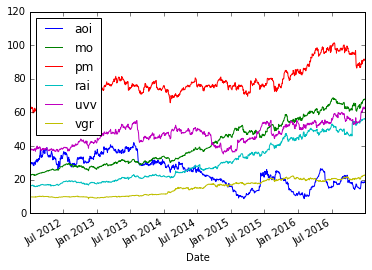

In [4]:
# Plot the last 5 years of closing stock prices
stock_price.info()
stock_price.plot()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 6 columns):
aoi    1258 non-null int64
mo     1258 non-null int64
pm     1258 non-null int64
rai    1258 non-null int64
uvv    1258 non-null int64
vgr    1258 non-null int64
dtypes: int64(6)
memory usage: 68.8 KB


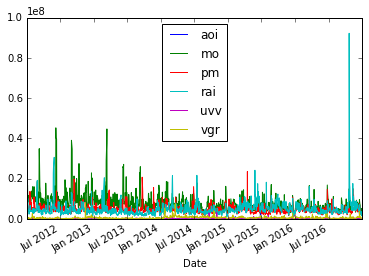

In [5]:
# Plot 5 years of volume transactions
stock_vol.info()
stock_vol.plot()

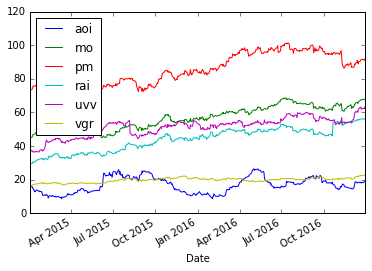

In [6]:
# Plot stock closing prices for the years 2015 and 2016
stock_price.ix['2015':'2016'].plot()

#### Data Structure
In this section, we are interested in investigating the strucure of our TS data. One of the assumptions in TS is dependency of the observations. Stationary analysis is one of the method to verify the dependency assumption.   


##### Stationary 
A TS is stationary when the mean and variance remain constant over time. This is important since there is a high probability that it will follow the same trend in the future. Stationary condition follows the folowing criteria:
* constant mean
* constant variance
* autocovariance doesn not depend on time

For the sake of simplicity, we are going to experiment with only 1 stock (MO) and a time range of only 2 years (2015-2016). At this point, it is difficult to visually conclude that the data is stationary. A proper method is to utilize the Dicky-Fuller test to determine if there is a stationary condition.

The following is Dicky-Fuller test method in Python. It is a test of null-hypothesis, where the null hypothesis is that the data is non-stationary. If the test statistic is less than the critical value, we can reject the null hypothesis and say that the series is stationary.  
The main part of the code is "adfuller" function, which is a python package of Augmented Dickey-Fuller test. We also used AIC as the autolag option, which will choose the number of lags given a set of data. 

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=22)
    rolstd = pd.rolling_std(timeseries, window=22)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

(504,)


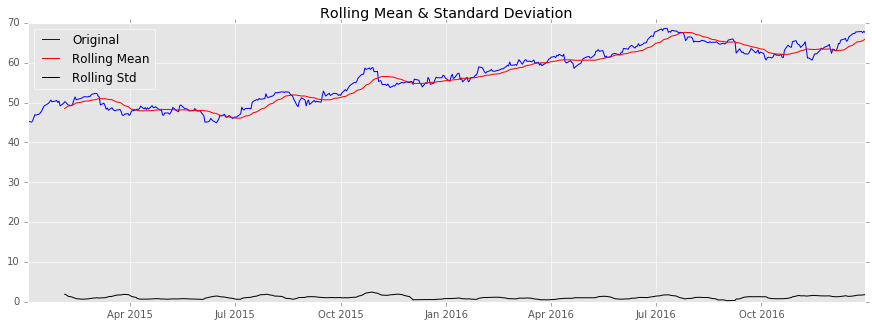

Results of Dickey-Fuller Test:
Test Statistic                  -1.053558
p-value                          0.733233
#Lags Used                       0.000000
Number of Observations Used    503.000000
Critical Value (5%)             -2.867303
Critical Value (1%)             -3.443418
Critical Value (10%)            -2.569840
dtype: float64


In [8]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sp_mo1516 = pd.Series(stock_price.mo['2015':'2016'])
print (sp_mo1516.shape)
test_stationarity(sp_mo1516)

It is obvious that there is an overall up and down trend in the data without any seasonal trend. Furthermore, the trend is clearly moving upward along with time.

Although the variation in standard deviation is small, the mean is clearly increasing with time. Since we have a p-value of 0.73 with 95% confidence level, this is not a stationary series. Also, the test statistic of -1.053558 is more than the critical value of -2.867303.

The next step would be to bring the data series closer towards a stationary condition.

There are two primary causes of non-stationarity in TS data, they are trend and seasonality.  Trend causes variation of means over time and seasonality causes variations within a period of time. Naturally in order to be able to perform statistical prediction, we need to eliminate these 2 major factors. 

#### Estimating and Eliminating Trend

##### Differencing

One of the most common techniques to reduce variations in statistics is by logarithmic transformation. We can apply this method also to our time series data. 

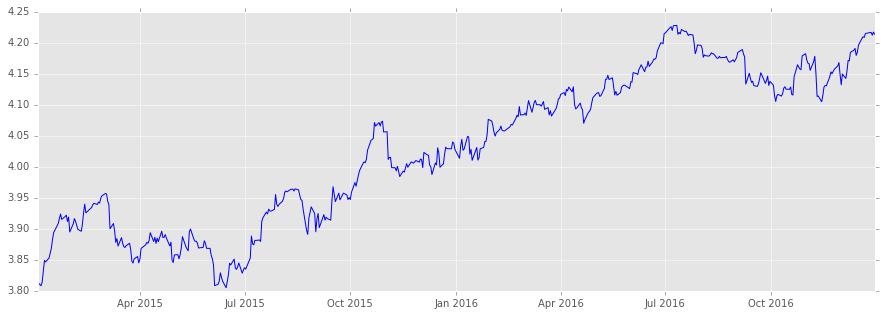

In [9]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sp_mo1516_log = np.log(sp_mo1516)
plt.plot(sp_mo1516_log, color='b')

By looking at the y axis, it is clear that the variation in the data had been reduced by a factor of 100. 
Moving forward, we notice that the noise and random variations are presence in the series. We can use rolling averages technique in order to reduce them. This techniques is known as Smoothing or Moving Average. 

##### Moving Average
This method is mainly to reduce or cancel the effects due to random variation. This technique, may reveals more clearly the underlying trend, seasonal and cyclic events. We decided to move 15 (3 weeks) observations per step in this process.

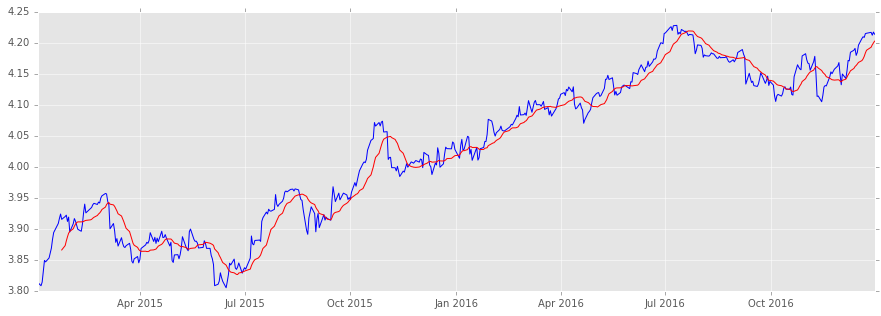

In [10]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
moving_avg = pd.rolling_mean(sp_mo1516_log, 15)
plt.plot(sp_mo1516_log, color='b')
plt.plot(moving_avg, color='r')

The red plot shows the result of "smoothing" process of the data. On the following Series, notice that the first 14 observations are "NaN", since we need the first 14 values in order to calculate the first moving average value.   

In [11]:
sp_mo1516_moving_avg_diff = sp_mo1516_log - moving_avg
sp_mo1516_moving_avg_diff.head(18)

Date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
2015-01-09         NaN
2015-01-12         NaN
2015-01-13         NaN
2015-01-14         NaN
2015-01-15         NaN
2015-01-16         NaN
2015-01-20         NaN
2015-01-21         NaN
2015-01-22         NaN
2015-01-23    0.049345
2015-01-26    0.046889
2015-01-27    0.041502
2015-01-28    0.024853
Name: mo, dtype: float64

We then drop all "NaN" observations and run Dickey-Fuller stationary test.

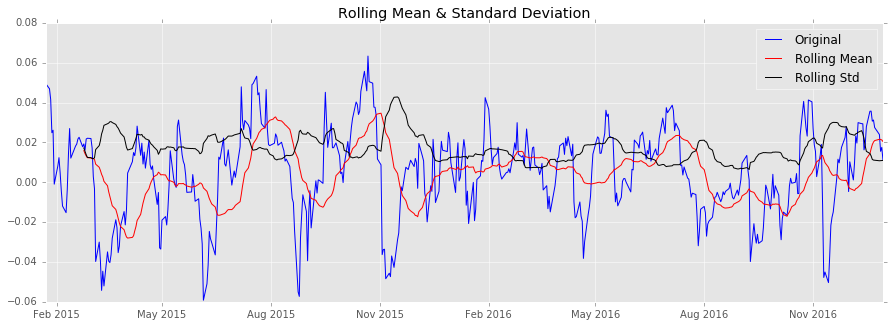

Results of Dickey-Fuller Test:
Test Statistic                -6.119978e+00
p-value                        8.903729e-08
#Lags Used                     5.000000e+00
Number of Observations Used    4.840000e+02
Critical Value (5%)           -2.867530e+00
Critical Value (1%)           -3.443933e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


In [12]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sp_mo1516_moving_avg_diff.dropna(inplace=True)
test_stationarity(sp_mo1516_moving_avg_diff)

From the plot above, we were able to improve the stationarity of the TS data. There is no obvious trend of the rolling average plot and test statistic is much smaller than 5% critical value with 95% confidence level. We can conclude that the series is now stationary.  

In many situations, it is difficult to define a good time period to average, such as yearly or monthly. In this case we can take a weighted moving average, where more recent values are given a higher weight.  One of the techiniques in assigning the weights is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.  
In the following step, we apply the same set of data using this technique. We decided to use half-life value of 10 as the amount of expoential decay.

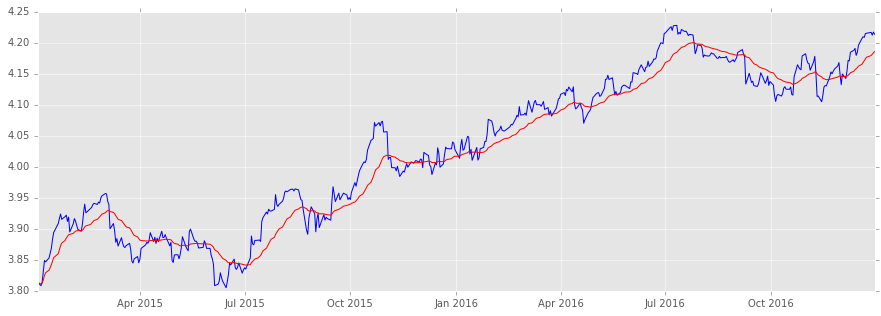

In [13]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
expwighted_avg = pd.ewma(sp_mo1516_log, halflife=10)
plt.plot(sp_mo1516_log, color='b')
plt.plot(expwighted_avg, color='r')

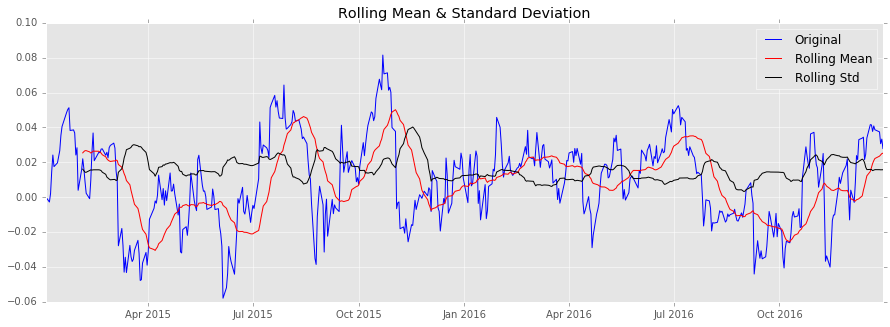

Results of Dickey-Fuller Test:
Test Statistic                  -4.799905
p-value                          0.000054
#Lags Used                       0.000000
Number of Observations Used    503.000000
Critical Value (5%)             -2.867303
Critical Value (1%)             -3.443418
Critical Value (10%)            -2.569840
dtype: float64


In [14]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sp_mo1516_log_ewma_diff = sp_mo1516_log - expwighted_avg
test_stationarity(sp_mo1516_log_ewma_diff)

In this particular case, the result shows more variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 5% critical value (95% confidence level) but it is not better than the previous case. Note that in this case there is no missing values as all values from starting are given weights.

#### Eliminating Seasonality

The simple trend reduction techniques discussed before do not work in all cases, particularly the ones with high seasonality. 
The techniques that can be used to eliminate trend and seasonality are Differencing and Decomposition.

##### Differencing
In this technique, we take the difference of the observation at a particular instant with that at the previous instant. Notice that the first observation will be eliminated ("NaN") and dropped.

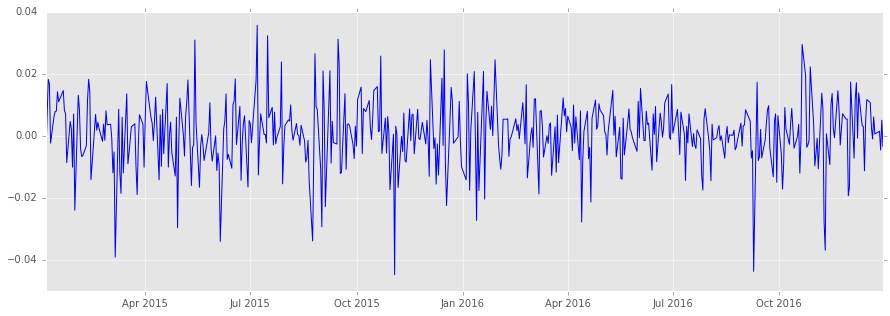

In [15]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sp_mo1516_log_diff = sp_mo1516_log - sp_mo1516_log.shift()
plt.plot(sp_mo1516_log_diff, color='b')

In [16]:
sp_mo1516_log_diff.head(5)

Date
2015-01-02         NaN
2015-01-05   -0.005734
2015-01-06    0.005938
2015-01-07    0.018208
2015-01-08    0.016700
Name: mo, dtype: float64

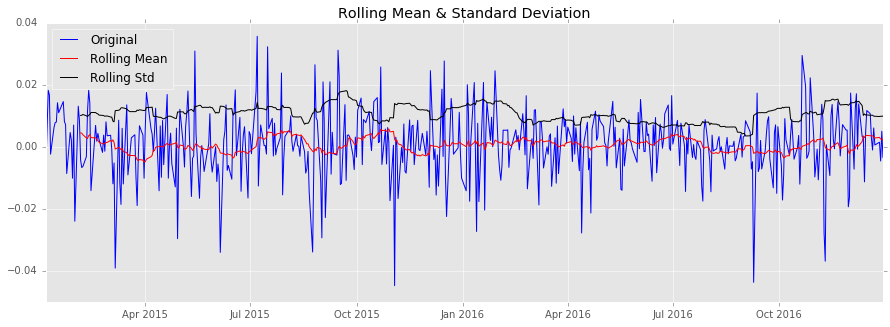

Results of Dickey-Fuller Test:
Test Statistic                 -22.767322
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    502.000000
Critical Value (5%)             -2.867315
Critical Value (1%)             -3.443444
Critical Value (10%)            -2.569846
dtype: float64


In [17]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sp_mo1516_log_diff.dropna(inplace=True)
test_stationarity(sp_mo1516_log_diff)

Based on the above plot, visually we can see that the moving average and standard deviation are significantly lower over time in comparison to the previous result. Dickey-Fuller test is also showing less than 5% critical value (95% confidence level). 

#### Decomposing
In this technique, both trend and seasonality are modeled separately and the remaining part of the series is returned.

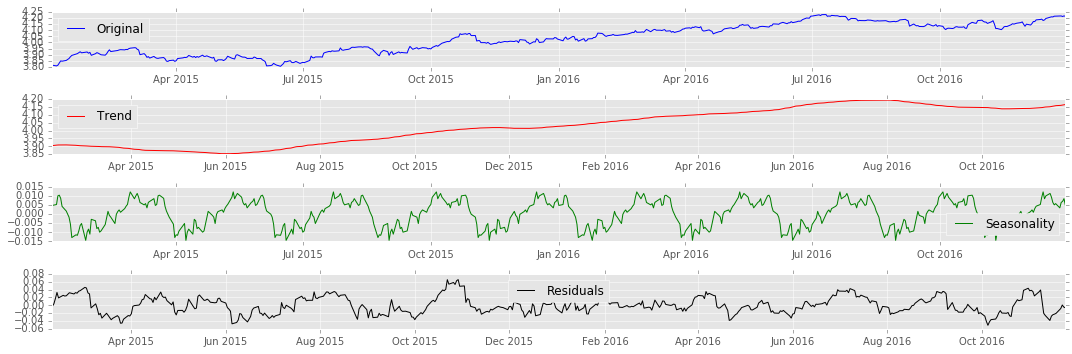

In [18]:
# Create a DataFrame with Series
df = pd.DataFrame(sp_mo1516_log)

# Get the time index from Series
idx = pd.DatetimeIndex(sp_mo1516_log.index)
df.set_index(idx, inplace=True)

# Resample using weekday frequency
df2 = df.resample('B').mean()

# Fill in missing values with interpolate
df2.mo.interpolate(inplace=True)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2.mo)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.subplot(411)
plt.plot(sp_mo1516_log, label='Original', color='b')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='r')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='g')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='k')
plt.legend(loc='best')
plt.tight_layout()


We can see that we were able to extract residuals plot from trend and seasonality. We can then model the residuals and run stationary test.

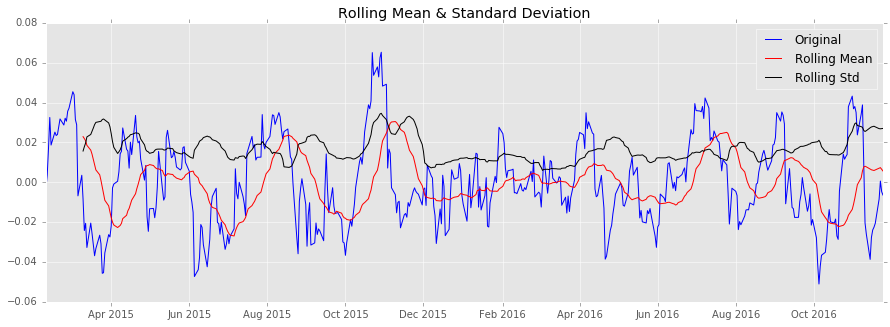

Results of Dickey-Fuller Test:
Test Statistic                -6.270419e+00
p-value                        4.017034e-08
#Lags Used                     6.000000e+00
Number of Observations Used    4.620000e+02
Critical Value (5%)           -2.867816e+00
Critical Value (1%)           -3.444584e+00
Critical Value (10%)          -2.570113e+00
dtype: float64


In [19]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sp_mo1516_log_decompose = residual
sp_mo1516_log_decompose.dropna(inplace=True)
test_stationarity(sp_mo1516_log_decompose)

The test statistic result is lower than 5% critical value (95% confidence level). We can conclude that the TS data is stationary. In the next section, we are going to demonstrate forecasting with TS data.

### Forecasting Time Series Data

In statistics, ARIMA (Autoregressive Integrated Moving Average) model is a generalization of an ARMA (Autoregressive Moving Average) model. Both of these models are can be used to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing can be applied to reduce the non-stationarity.

The ARIMA forecasting for a stationary TS data is similar to a linear equation. The predictors depend on the parameters of Auto-Regresive (AR), Moving Average (MA) and Differencing (Integrated). AR is lags of dependent variable in TS data. Together with the moving-average (MA) model, they are key component of the more general ARMA and ARIMA models of time series. Differencing is the number of nonseasonal differences. Seasonal difference in a TS data is the series of changes from one season to the next. In this case the number is the determination of the order of differencing needed to stationarize the series (eliminate trends).



To determine the value of AR and MA, we can use 2 different plots. There are Autocorrelation Function (ACF) and Partial Autocorrelation Function(PACF).
ACF is is a measure of the correlation between the the TS with a lagged version of itself.
PACF is  is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

In [20]:
from statsmodels.tsa.stattools import acf, pacf

In [21]:
# Show 15 days for the plot
lag_acf = acf(sp_mo1516_log_diff, nlags=15)
lag_pacf = pacf(sp_mo1516_log_diff, nlags=15)

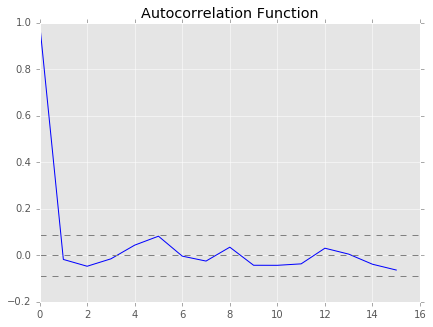

In [22]:
#Plot ACF:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.subplot(121) 
plt.plot(lag_acf, color='b')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(sp_mo1516_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(sp_mo1516_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

From the chart above the lag value of ACF is shown at around day 5. 

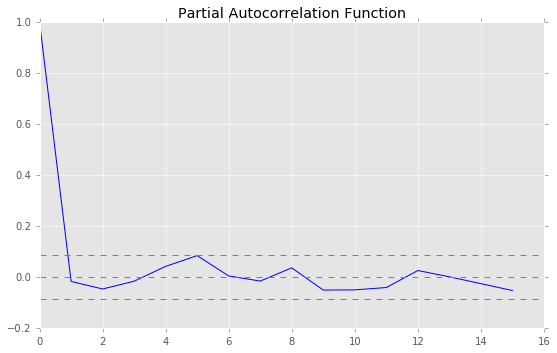

In [23]:
#Plot PACF:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.subplot(122)
plt.plot(lag_pacf, color='b')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(sp_mo1516_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(sp_mo1516_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

For PACF, the lag value is also shown at around day 5.  
For the next step, we can use these values to construct AR and MA model and the combination of both (ARIMA). 

##### AR Model

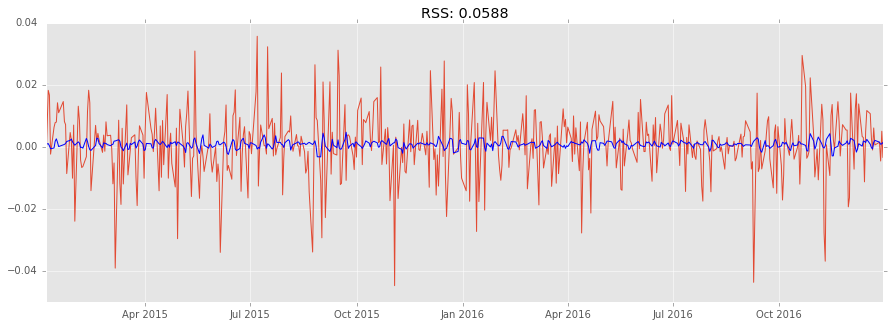

In [24]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
model = sm.tsa.ARIMA(sp_mo1516_log, order=(5, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(sp_mo1516_log_diff)
plt.plot(results_AR.fittedvalues, color='b')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-sp_mo1516_log_diff)**2))

In the above model, we passed tuple value of (5, 1, 0) to reflect ACF lag value of 5, differencing order of 1 and disregard PACF. Our RSS value for the residual 0.0588 

##### MA Model

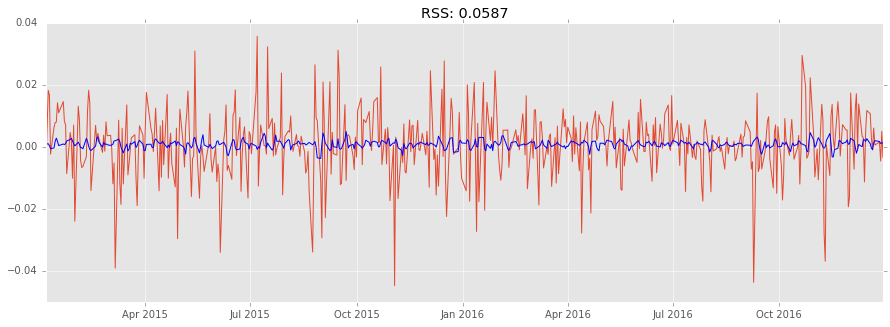

In [25]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
model = sm.tsa.ARIMA(sp_mo1516_log, order=(0, 1, 5))  
results_MA = model.fit(disp=-1)  
plt.plot(sp_mo1516_log_diff)
plt.plot(results_MA.fittedvalues, color='b')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-sp_mo1516_log_diff)**2))

In the MA model, we passed tuple value of (0, 1, 5) to reflect PACF lag value of 5, differencing order of 1 and disregard ACF. Our RSS value for the residual 0.0587 

##### ARIMA Model (Combination)

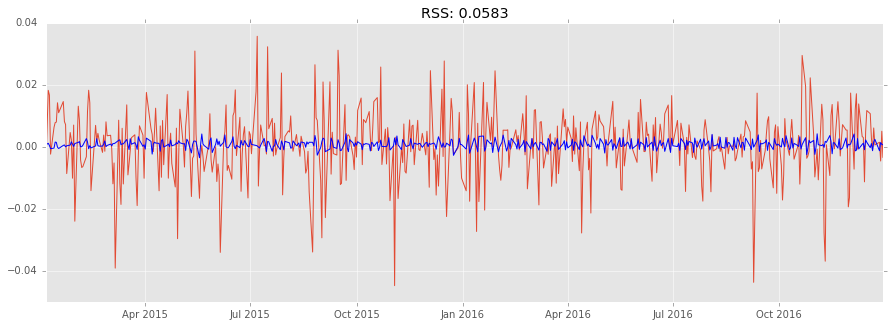

In [26]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
model = sm.tsa.ARIMA(sp_mo1516_log, order=(5, 1, 5))
results_ARIMA = model.fit(disp=-1)  
plt.plot(sp_mo1516_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='b')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-sp_mo1516_log_diff)**2))

Here we can see that the combination of AR and MA models with RSS value of 0.0582 is lower than either AR or MA.  
Our next step is to the original stock value and implement based on it. 

First, we store the predicted result from ARIMA separately and observe it. 

In [27]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Date
2015-01-05    0.000813
2015-01-06    0.000879
2015-01-07    0.001137
2015-01-08    0.000427
2015-01-09   -0.000612
dtype: float64


Notice that these start from ‘2015-01-05’ since we took a lag by 5 days and first element doesn’t have anything before it to subtract from.  
We then convert the differencing to log scale by adding differences consecutively to the base number. 

In [28]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Date
2015-01-05    0.000813
2015-01-06    0.001691
2015-01-07    0.002828
2015-01-08    0.003255
2015-01-09    0.002643
dtype: float64


Next, we add to them to base log number.  

In [29]:
predictions_ARIMA_log = pd.Series(sp_mo1516_log.ix[0], index=sp_mo1516_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2015-01-02    3.813921
2015-01-05    3.814734
2015-01-06    3.815613
2015-01-07    3.816749
2015-01-08    3.817176
dtype: float64

Finally, we convert back the value from log by taking the exponenent.  We are also showing the comparison of the transformed TS data with the original values. 

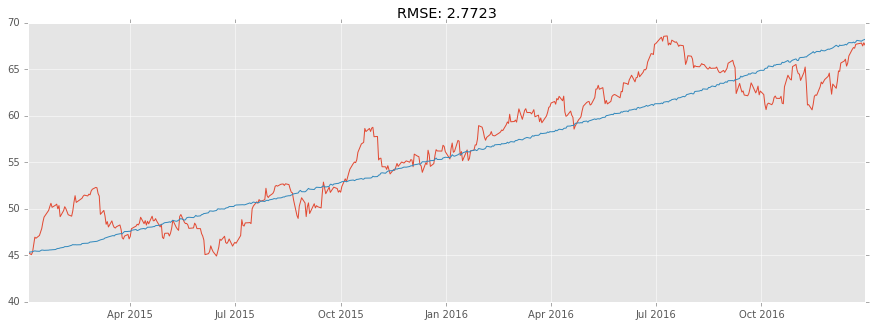

In [30]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.plot(sp_mo1516)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-sp_mo1516)**2)/len(sp_mo1516)))

### Signal Frontier Analysis

Plot of cumulative returns for the Tobacco stocks from 1/1/2012 to 12/31/2016. In addition, we added a SPDR ETF ("SPY") that tracks the S&P 500, which will let us compare to the overall market returns (shown in black in the chart below). We note that RAI, MO, and VGR offered superior returns to the overall market for this holding period.

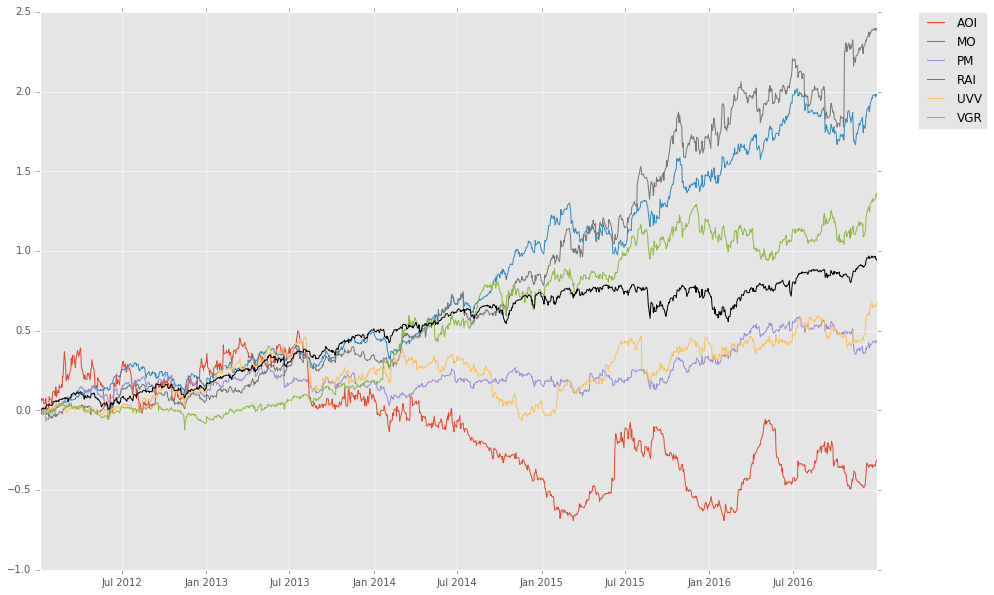

In [31]:
# Tobacco shares we would like to analyze
names = ['MO', 'PM', 'RAI', 'VGR', 'AOI', 'UVV']
spy = ['SPY']

# Function to grab stock data from the web
def get_px(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Adj Close']

# Create a DataFrame for the range we are interested in
px = pd.DataFrame({n: get_px(n, '1/1/2012', '12/31/2016') for n in names})
sp500 = pd.DataFrame({n: get_px(n, '1/1/2012', '12/31/2016') for n in spy})

# Plot the cumulative return
px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()
px1 = ((1 + rets).cumprod() - 1)
sp500 = sp500.asfreq('B').fillna(method='pad')
rets = sp500.pct_change()
px2 = ((1 + rets).cumprod() - 1)
plt.figure(figsize=(15, 10))
plt.style.use('ggplot')
plt.plot(px1)
plt.legend(px1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot(px2, color='k')

Sharpe Ratio measures the efficiency of a portfolio. It was created by William Sharpe in an effort to create a metrics for volatility risk adjusted return. It is widely accepted as a benchmark to measure Hedge Fund performance. Sharpe Ratio is defined as:

    Sharpe Ratio = [R_p - R_f] / Sigma_p  
    
    Where:
        * R_p = return on the portfolio
        * R_f = risk free Rate (such as bank interest or short term treasury bond)
        * Sigma_p = Standard Deviation of the returns
        
One can infer from this calculation is that a portfolio which engages in a "zero risk" investment, such as U.S. Treasury Bills has a Sharpe ratio of zero. Since the expected return for U.S. Treasury Bills is a risk-free rate, this is what is expected. In general, the greater the value for the Sharpe ratio, the more attractive the risk-adjusted return.

However, it must be kept in mind that the Sharpe ratio is not accurate if applied to portfolios which do not have a normal distribution of expected returns. Some assets are highly skewed or have high degree of kurtosis (fat tails). It also fails when analyzing high risk non-linear assets such as options or warrants.

The following function computes the momentum over a certain lookback period and ranks it in ascending order and standardizes.

In [32]:
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

To return the overall Sharpe ratio, we can use this transform function and set up a backtesting function which computes a portfolio for a particular lookback and holding period (days between trading).

In [33]:
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)
    daily_rets = prices.pct_change()
    # Compute portfolio returns
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [34]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px, lb, hold)

ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [35]:
def heatmap(df, cmap=plt.cm.RdYlGn):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

Heatmap of momentum strategy Sharpe ratio (higher is better) over various lookbacks and holding periods.

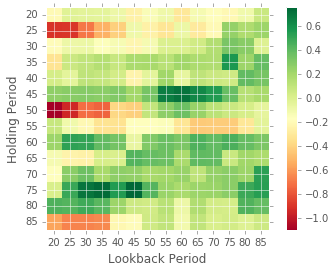

In [36]:
heatmap(ddf)

We can determine the optimal Sharpe Ratio by finding the highest value in the DataFrame. The optimal holding/loopback period is 75/45.

In [37]:
# max for each row
maxForRow = ddf.max(axis=0)
globalMax = maxForRow.max()
print "Max Sharpe Ratio is: %f" % globalMax
ddf[ddf.values==globalMax]

Max Sharpe Ratio is: 0.761546


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
75,0.016676,0.497377,0.709613,0.745378,0.551457,0.761546,0.429929,0.232172,0.182941,0.226039,0.236256,0.276103,0.487526,0.536736


We can determine the least optimal Sharpe Ratio by find the lowest value in the DataFrame. The least optimal holding/loopback period is 50/20.

In [38]:
# min for each row
minForRow = ddf.min(axis=0)
globalMin = minForRow.min()
print "Min Sharpe Ratio is: %f" % globalMin
ddf[ddf.values==globalMin]

Min Sharpe Ratio is: -1.096345


Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
50,-1.096345,-0.939674,-0.722841,-0.750153,-0.381109,-0.413691,0.09458,0.269945,0.365602,0.240581,0.130143,0.06512,0.025677,-0.046808


### Conclusion
Time series analysis is a method for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previous values. It accounts for the fact that data points taken over period of time may have an internal structure such as trend or seasonal variations that should be considered for.

Using Signal Frontier Analysis, it is possible to analyze a basket of securities and find the optimal holding and lookback periods, which yields the highest Sharpe Ratio. Backtesting is a common practice to test various algorithms and portfolios as well as used as a comparison to study a portfolio's overall risk-return characteristics when a new asset or class has been added to it. It can be used to help a portfolio manager determine whether their additional allocation of assets has improved the risk-return dynamics. In addition, it can be used to judge whether excessive returns are due to smart investments or as a result of excessive risk taking. If a Sharpe ratio has fallen negative, it indicates that a risk free asset would perform better than the portfolio or assets being analyzed.

With the enormous amount of functionality and flexibility that Python/Pandas provides for analyzing Time Series data, the applications are numerous and expand well beyond just the financial industry.

### References

McKinney, W. (2012) Python for Data Analysis. Oreilly Media.  
Jain, A. A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python) (2016). Retrieved February 1, 2017, from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/.  
Penn State Eberly College of Science. Applied Time Series Analysis (2017). Retrieved February 1, 2017, from https://onlinecourses.science.psu.edu/stat510/node/33.
